In [75]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset

In [87]:
weather_data = pd.read_csv('/Users/llukii/Downloads/seattle-weather.csv')
weather_data.set_index('date', inplace=True)
unique_climate = weather_data['weather'].unique()
weather_data['weather'] = weather_data['weather'].map({climate : idx for idx, climate in enumerate(unique_climate)})
weather_data

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-01,0.0,12.8,5.0,4.7,0
2012-01-02,10.9,10.6,2.8,4.5,1
2012-01-03,0.8,11.7,7.2,2.3,1
2012-01-04,20.3,12.2,5.6,4.7,1
2012-01-05,1.3,8.9,2.8,6.1,1
...,...,...,...,...,...
2015-12-27,8.6,4.4,1.7,2.9,1
2015-12-28,1.5,5.0,1.7,1.3,1
2015-12-29,0.0,7.2,0.6,2.6,4


In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [6]:
weather_data.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


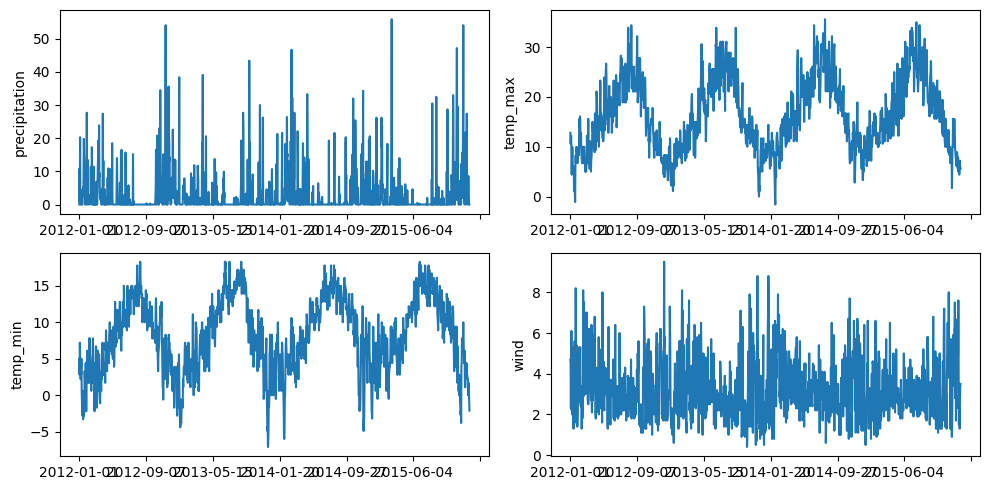

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
for i, col in enumerate(weather_data.columns):
    if i == 4: break
    plt.subplot(2, 2, i+1)
    weather_data[col].plot()
    plt.xlabel(None)
    plt.ylabel(col)

fig.tight_layout()

In [90]:
# consider weather from the last two weeks
scalar = MinMaxScaler()
scalar.fit(weather_data)
weather_data = scalar.transform(weather_data)

train_x, train_y = [], []
for idx in range(weather_data.shape[0]):
    if idx >= 14:
        train_x.append(weather_data[idx-14:idx, :-1])
        train_y.append(weather_data[idx, -1])

np.array(train_x).shape

(1447, 14, 4)

In [69]:
batch_size = 64
class Weather(Dataset):
    def __init__(self): pass
    def __len__(self): return len(train_x)
    def __getitem__(self, idx): return train_x[idx], train_y[idx]

train_loader = DataLoader(Weather(), batch_size=batch_size, shuffle=True)

In [70]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=32,
            batch_first=True
        )
        self.linear = nn.Linear(32, 6)

    def forward(self, x):
        x = self.linear(self.lstm(x))
        return x

In [71]:
model = NeuralNet()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()